### SIR 模型接種疫苗後的變化

#### SIR original model

In [1]:
from pylab import *
from scipy import interpolate
import numpy as np

beta = 1
beta_v = 0.4  # 施打疫苗後的人群的beta
gamma = 0.6
N = 10000  # 總人口數
day = 50  # 傳染病開始散佈後50天
I0 = 10  # 一開始被感染的人數
start_inject = 10  # 20天後開始打疫苗

以一天為一個回次，一天後計算S, I, R各自的變化量

In [2]:
def SIR_og(S, I, R):

    #  建立原始模型
    dS = - beta*I*S/N
    dI = beta*I*S/N - gamma*I
    dR = gamma * I

    # 把變化量加回去
    s = S + dS
    i = I + dI
    r = R + dR

    # 邊界條件
    if s < 0:
        s = 0
    if i > N:
        i = N
    if r > N:
        r = N

    return s, i, r

#### SIR施打疫苗後T日內，未有抗體者還未產生出抗體

In [3]:
def SIR_in_T(S, I, R, V):

    # 建立有施打疫苗、但還未生效的模型
    if S > injected_n:
        dS = - beta*I*S/N - injected_n
    elif (S <= injected_n) and (S > 0):
        dS = -S
    elif S == 0:
        dS = 0
    dI = beta*S*I/N + beta*V*I/N -gamma*I
    dR = gamma*I
    if S > injected_n:
        dV = - beta*I*V/N + injected_n
    elif (S <= injected_n) and (S > 0):
        dV = - beta*I*V/N + (S-beta*I*S/N)
    elif S == 0:
        dV = -beta*I*V/N

    # 把變化量加回去
    s = S + dS
    i = I + dI
    r = R + dR
    v = V + dV

    # 邊界條件
    if s < 0:
        s = 0
        v = V
    if i > N:
        i = N
    if r > N:
        r = N
    if v <= 0:
        v = 0
    if v > N:
        v = N

    return s, i, r, v

#### T日後，已經產生抗體的模型

In [4]:
def SIR_after_T(S, I, R, V):

    # 建立施打疫苗後已經產生抗體的模型
    # 所以施打疫苗後的V人群的beta變成beta_v
    if S > injected_n:
        dS = - beta*I*S/N - injected_n
    elif (S < injected_n) and (S > 0):
        dS = -S
    elif S == 0:
        dS = 0
    dI = beta*S*I/N + beta_v*V*I/N -gamma*I
    dR = gamma*I
    if S > injected_n:
        dV = - beta_v*I*V/N + injected_n
    elif (S <= injected_n) and (S > 0):
        dV = - beta_v*I*V/N + (S-beta*I*S/N)
    elif S == 0:
        dV = -beta_v*I*V/N

    # 把變化量加回去
    s = S + dS
    i = I + dI
    r = R + dR
    v = V + dV

    # 設定邊界條件
    if s < 0:
        s = 0
    if i > N:
        i = N
    if r > N:
        r = N
    if v < 0:
        v = 0
    if v > N:
        v = N

    return s, i, r, v

### 原始沒有打疫苗的圖

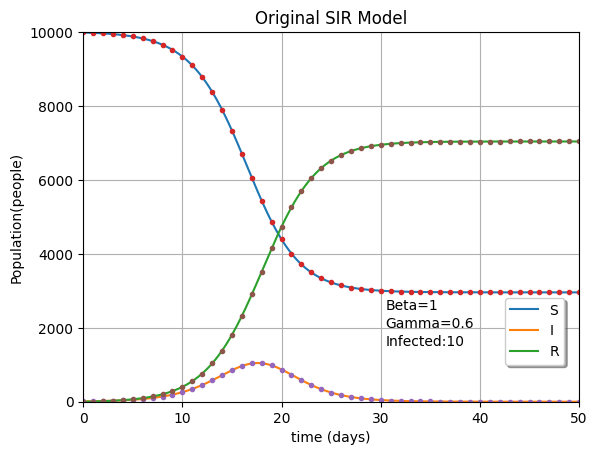

In [7]:
# 設定初始值
I = I0
S = N - I0
R = 0

# 創立列表
LS = [S]
LI = [I]
LR = [R]

# 開始跑50天
for i in range(0, day):
    S, I, R = SIR_og(S, I, R)

    LS.append(S)
    LI.append(I)
    LR.append(R)

# Draw the figure
t = arange(0, day+1, 1)
ls = interpolate.InterpolatedUnivariateSpline(t, LS)
li = interpolate.InterpolatedUnivariateSpline(t, LI)
lr = interpolate.InterpolatedUnivariateSpline(t, LR)
tnew = arange(0.001, day, 1/50)
lsnew = ls(tnew)
linew = li(tnew)
lrnew = lr(tnew)
line1, = plot(tnew, lsnew, label='S')
line2, = plot(tnew, linew, label='I')
line3, = plot(tnew, lrnew, label='R')

legend(handles=[line1, line2, line3],
        shadow=True, loc=(0.85, 0.1))  # handle

line11, = plot(t, LS, '.')
line22, = plot(t, LI, '.')
line33, = plot(t, LR, '.')

text(30.5, 2500, 'Beta=%g' % (beta))
text(30.5, 2000, 'Gamma=%g' % (gamma))
text(30.5, 1500, 'Infected:%d' % (I0))
v = [0, 50, 0, 10000]
axis(v)
xlabel('time (days)')
ylabel('Population(people)')
title('Original SIR Model')
grid(True)
show()

### 有打疫苗的圖 injected_n = 100, T= 7

In [8]:
injected_n = 100  # 每日打100個人
T = 7  # 疫苗七天後生效

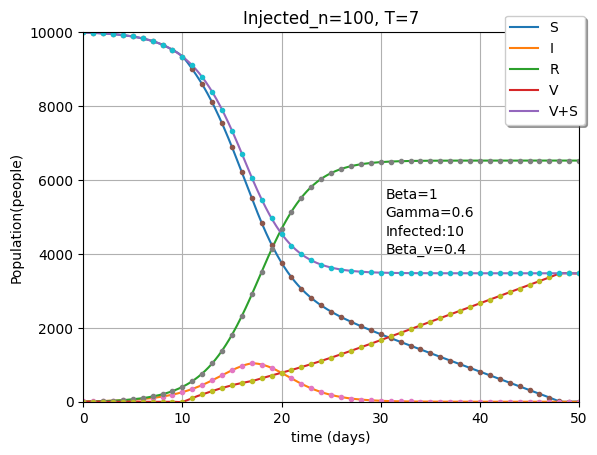

In [10]:
# 設定初始值
I = I0
S = N - I0
R = 0
V = 0

# 建立列表
LS = [S]
LI = [I]
LR = [R]
LV = [V]
LSV = [S]

# 用原始模型跑0到開始打疫苗的天數
for i in range(0, start_inject):
    S, I, R = SIR_og(S, I, R)

    LS.append(S)
    LI.append(I)
    LR.append(R)
    LV.append(0)
    LSV.append(S)

# 用"未生效的SIR model"開始打疫苗的天數跑到開始生效的天數
for i in range(start_inject, start_inject+T):
    S, I, R, V = SIR_in_T(S, I, R, V)

    LS.append(S)
    LI.append(I)
    LR.append(R)
    LV.append(V)
    LSV.append(V+S)

# 用"生效的SIR model"開始生效的天數跑到最後一天
for i in range(start_inject+T, day):
    S, I, R, V = SIR_after_T(S, I, R, V)

    LS.append(S)
    LI.append(I)
    LR.append(R)
    LV.append(V)
    LSV.append(V+S)

# Draw the figure
t = arange(0, day+1, 1)
ls = interpolate.InterpolatedUnivariateSpline(t, LS)
li = interpolate.InterpolatedUnivariateSpline(t, LI)
lr = interpolate.InterpolatedUnivariateSpline(t, LR)
lv = interpolate.InterpolatedUnivariateSpline(t, LV)
lsv = interpolate.InterpolatedUnivariateSpline(t, LSV)
tnew = arange(0.001, day, 1/50)
lsnew = ls(tnew)
linew = li(tnew)
lrnew = lr(tnew)
lvnew = lv(tnew)
lsvnew = lsv(tnew)
line1, = plot(tnew, lsnew, label='S')
line2, = plot(tnew, linew, label='I')
line3, = plot(tnew, lrnew, label='R')
line4, = plot(tnew, lvnew, label='V')
line5, = plot(tnew, lsvnew, label='V+S')

legend(handles=[line1, line2, line3, line4, line5],
        shadow=True, loc=(0.85, 0.75))  # handle

line11, = plot(t, LS, '.')
line22, = plot(t, LI, '.')
line33, = plot(t, LR, '.')
line44, = plot(t, LV, '.')
line55, = plot(t, LSV, '.')

text(30.5, 5500, 'Beta=%g' % (beta))
text(30.5, 5000, 'Gamma=%g' % (gamma))
text(30.5, 4500, 'Infected:%d' % (I0))
text(30.5, 4000,  'Beta_v=%g' % (beta_v))
v = [0, 50, 0, 10000]
axis(v)
xlabel('time (days)')
ylabel('Population(people)')
title('Injected_n=100, T=7')
grid(True)
show()

### injected_n = 100, T = 14

In [11]:
injected_n = 100  # 每日打100個人
T = 14  # 疫苗14天後生效

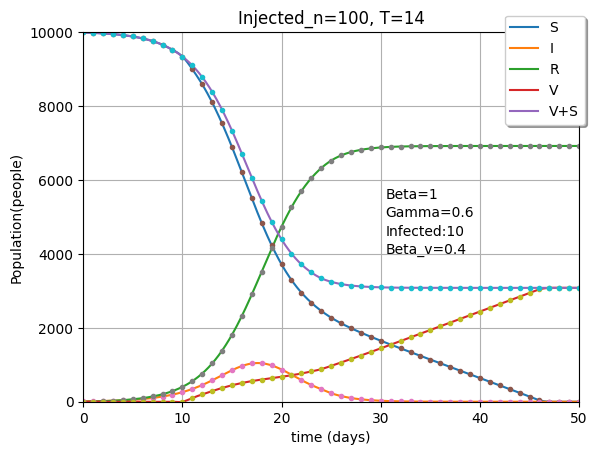

In [12]:
I = I0
S = N - I0
R = 0
V = 0

LS = [S]
LI = [I]
LR = [R]
LV = [V]
LSV = [S]

for i in range(0, start_inject):
    S, I, R = SIR_og(S, I, R)

    LS.append(S)
    LI.append(I)
    LR.append(R)
    LV.append(0)
    LSV.append(S)

for i in range(start_inject, start_inject+T):
    S, I, R, V = SIR_in_T(S, I, R, V)

    LS.append(S)
    LI.append(I)
    LR.append(R)
    LV.append(V)
    LSV.append(V+S)

for i in range(start_inject+T, day):
    S, I, R, V = SIR_after_T(S, I, R, V)

    LS.append(S)
    LI.append(I)
    LR.append(R)
    LV.append(V)
    LSV.append(V+S)

# Draw the figure
t = arange(0, day+1, 1)
ls = interpolate.InterpolatedUnivariateSpline(t, LS)
li = interpolate.InterpolatedUnivariateSpline(t, LI)
lr = interpolate.InterpolatedUnivariateSpline(t, LR)
lv = interpolate.InterpolatedUnivariateSpline(t, LV)
lsv = interpolate.InterpolatedUnivariateSpline(t, LSV)
tnew = arange(0.001, day, 1/50)
lsnew = ls(tnew)
linew = li(tnew)
lrnew = lr(tnew)
lvnew = lv(tnew)
lsvnew = lsv(tnew)
line1, = plot(tnew, lsnew, label='S')
line2, = plot(tnew, linew, label='I')
line3, = plot(tnew, lrnew, label='R')
line4, = plot(tnew, lvnew, label='V')
line5, = plot(tnew, lsvnew, label='V+S')

legend(handles=[line1, line2, line3, line4, line5],
        shadow=True, loc=(0.85, 0.75))  # handle

line11, = plot(t, LS, '.')
line22, = plot(t, LI, '.')
line33, = plot(t, LR, '.')
line44, = plot(t, LV, '.')
line55, = plot(t, LSV, '.')

text(30.5, 5500, 'Beta=%g' % (beta))
text(30.5, 5000, 'Gamma=%g' % (gamma))
text(30.5, 4500, 'Infected:%d' % (I0))
text(30.5, 4000,  'Beta_v=%g' % (beta_v))
v = [0, 50, 0, 10000]
axis(v)
xlabel('time (days)')
ylabel('Population(people)')
title('Injected_n=100, T=14')
grid(True)
show()

### injected_n = 500, T = 7

In [13]:
injected_n = 500  # 每日打500個人
T = 7  # 疫苗7天後生效

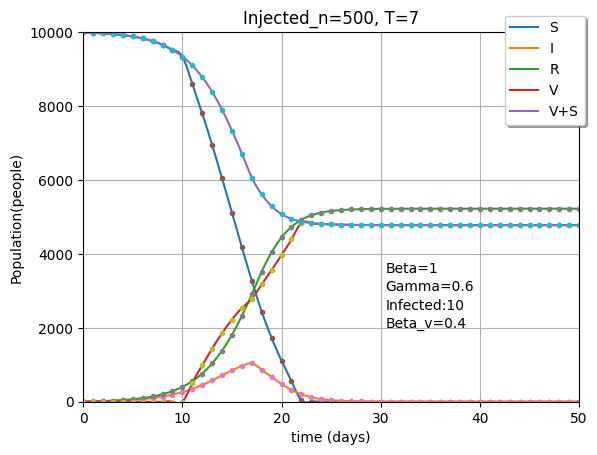

In [14]:

I = I0
S = N - I0
R = 0
V = 0

LS = [S]
LI = [I]
LR = [R]
LV = [V]
LSV = [S]

for i in range(0, start_inject):
    S, I, R = SIR_og(S, I, R)

    LS.append(S)
    LI.append(I)
    LR.append(R)
    LV.append(0)
    LSV.append(S)

for i in range(start_inject, start_inject+T):
    S, I, R, V = SIR_in_T(S, I, R, V)

    LS.append(S)
    LI.append(I)
    LR.append(R)
    LV.append(V)
    LSV.append(V+S)

for i in range(start_inject+T, day):
    S, I, R, V = SIR_after_T(S, I, R, V)

    LS.append(S)
    LI.append(I)
    LR.append(R)
    LV.append(V)
    LSV.append(V+S)

# Draw the figure
t = arange(0, day+1, 1)
ls = interpolate.InterpolatedUnivariateSpline(t, LS)
li = interpolate.InterpolatedUnivariateSpline(t, LI)
lr = interpolate.InterpolatedUnivariateSpline(t, LR)
lv = interpolate.InterpolatedUnivariateSpline(t, LV)
lsv = interpolate.InterpolatedUnivariateSpline(t, LSV)
tnew = arange(0.001, day, 1/50)
lsnew = ls(tnew)
linew = li(tnew)
lrnew = lr(tnew)
lvnew = lv(tnew)
lsvnew = lsv(tnew)
line1, = plot(tnew, lsnew, label='S')
line2, = plot(tnew, linew, label='I')
line3, = plot(tnew, lrnew, label='R')
line4, = plot(tnew, lvnew, label='V')
line5, = plot(tnew, lsvnew, label='V+S')

legend(handles=[line1, line2, line3, line4, line5],
        shadow=True, loc=(0.85, 0.75))  # handle

line11, = plot(t, LS, '.')
line22, = plot(t, LI, '.')
line33, = plot(t, LR, '.')
line44, = plot(t, LV, '.')
line55, = plot(t, LSV, '.')

text(30.5, 3500, 'Beta=%g' % (beta))
text(30.5, 3000, 'Gamma=%g' % (gamma))
text(30.5, 2500, 'Infected:%d' % (I0))
text(30.5, 2000,  'Beta_v=%g' % (beta_v))
v = [0, 50, 0, 10000]
axis(v)
xlabel('time (days)')
ylabel('Population(people)')
title('Injected_n=500, T=7')
grid(True)
show()

### injected_n = 500, T = 14

In [15]:
injected_n = 500  # 每日打500個人
T = 14  # 疫苗7天後生效

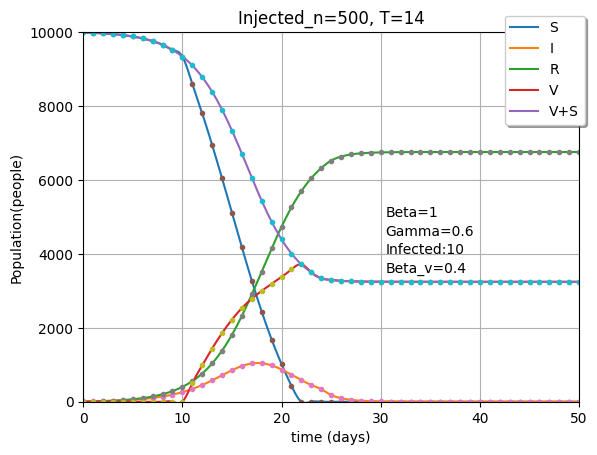

In [16]:
I = I0
S = N - I0
R = 0
V = 0

LS = [S]
LI = [I]
LR = [R]
LV = [V]
LSV = [S]

for i in range(0, start_inject):
    S, I, R = SIR_og(S, I, R)

    LS.append(S)
    LI.append(I)
    LR.append(R)
    LV.append(0)
    LSV.append(S)

for i in range(start_inject, start_inject+T):
    S, I, R, V = SIR_in_T(S, I, R, V)

    LS.append(S)
    LI.append(I)
    LR.append(R)
    LV.append(V)
    LSV.append(V+S)

for i in range(start_inject+T, day):
    S, I, R, V = SIR_after_T(S, I, R, V)

    LS.append(S)
    LI.append(I)
    LR.append(R)
    LV.append(V)
    LSV.append(V+S)

# Draw the figure
t = arange(0, day+1, 1)
ls = interpolate.InterpolatedUnivariateSpline(t, LS)
li = interpolate.InterpolatedUnivariateSpline(t, LI)
lr = interpolate.InterpolatedUnivariateSpline(t, LR)
lv = interpolate.InterpolatedUnivariateSpline(t, LV)
lsv = interpolate.InterpolatedUnivariateSpline(t, LSV)
tnew = arange(0.001, day, 1/50)
lsnew = ls(tnew)
linew = li(tnew)
lrnew = lr(tnew)
lvnew = lv(tnew)
lsvnew = lsv(tnew)
line1, = plot(tnew, lsnew, label='S')
line2, = plot(tnew, linew, label='I')
line3, = plot(tnew, lrnew, label='R')
line4, = plot(tnew, lvnew, label='V')
line5, = plot(tnew, lsvnew, label='V+S')

legend(handles=[line1, line2, line3, line4, line5],
        shadow=True, loc=(0.85, 0.75))  # handle

line11, = plot(t, LS, '.')
line22, = plot(t, LI, '.')
line33, = plot(t, LR, '.')
line44, = plot(t, LV, '.')
line55, = plot(t, LSV, '.')

text(30.5, 5000, 'Beta=%g' % (beta))
text(30.5, 4500, 'Gamma=%g' % (gamma))
text(30.5, 4000, 'Infected:%d' % (I0))
text(30.5, 3500,  'Beta_v=%g' % (beta_v))
v = [0, 50, 0, 10000]
axis(v)
xlabel('time (days)')
ylabel('Population(people)')
title('Injected_n=500, T=14')
grid(True)
show()